# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
%matplotlib inline

# Your code goes here
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.naive_bayes import BernoulliNB

/home/dsmarda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [2]:
# Your code goes here
data_path_train = os.path.join(os.getcwd(), "datasets", "train_images_partA.csv")
train_A = pd.read_csv(data_path_train, delimiter = ",")
print("Train: Number of instances: {}, number of attributes: {}".format(train_A.shape[0], train_A.shape[1]))
data_path_valid = os.path.join(os.getcwd(), "datasets", "valid_images_partA.csv")
valid_A = pd.read_csv(data_path_valid, delimiter = ",")
print("Validation: Number of instances: {}, number of attributes: {}".format(valid_A.shape[0], valid_A.shape[1]))

Train: Number of instances: 2093, number of attributes: 520
Validation: Number of instances: 1113, number of attributes: 520


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [3]:
# Your code goes here
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [4]:
# Your code goes here
att_list = []
for i in range(1, 501):
    att_list.append(train_A.columns[i])

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [5]:
# Your code goes here
X_tr = train_A[att_list].as_matrix()
X_val = valid_A[att_list].values
y_tr = train_A["is_person"].values
y_val = valid_A["is_person"].values
print ("Shape of X_tr:", X_tr.shape)
print ("Shape of X_val:", X_val.shape)
print ("Shape of y_tr:", y_tr.shape)
print ("Shape of y_val:", y_val.shape)

Shape of X_tr: (2093, 500)
Shape of X_val: (1113, 500)
Shape of y_tr: (2093,)
Shape of y_val: (1113,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

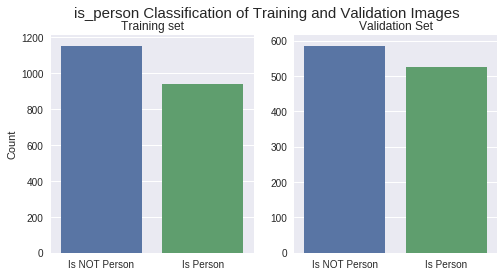

In [6]:
# Your code goes here
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sns.countplot(y_tr, ax=ax1)
ax1.set_title("Training set", size=12)
ax1.set_xlabel(" ")
ax1.set_ylabel("Count")
ax1.set_xticklabels(["Is NOT Person", "Is Person"])
sns.countplot(y_val, ax=ax2)
ax2.set_xlabel(" ")
ax2.set_ylabel(" ")
ax2.set_title("Validation Set", size=12)
ax2.set_xticklabels(["Is NOT Person", "Is Person"])
fig.suptitle("is_person Classification of Training and Validation Images", size=15)
plt.show()

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

The most basic baseline classifier is one that chooses always chooses the class that has the most instances in the training data. In our dataset, this means it would would classify each validation and test instance as "is NOT Person".

In [7]:
# Your code goes here
class_counts = train_A["is_person"].value_counts()
print ("Accuracy Score of Baseline Classifier on Validation Set: {:.3f}"\
      .format(class_counts[0]/class_counts.values.sum()))

Accuracy Score of Baseline Classifier on Validation Set: 0.551


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [8]:
# Your code goes here
lr = LogisticRegression(solver="lbfgs").fit(X=X_tr, y=y_tr)
print ("Accuracy Score of Logistic Regression on Training Data: {:.3f}"\
      .format(lr.score(X=X_tr, y=y_tr)))
print ("Accuracy Score of Logistic Regression on Validation Data: {:.3f}"\
      .format(lr.score(X=X_val, y=y_val)))

Accuracy Score of Logistic Regression on Training Data: 0.551
Accuracy Score of Logistic Regression on Validation Data: 0.527


The Logistic Regression classifier performed about as well as the baseline classifier, performing slightly worse on the validation data than the test data. 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [9]:
# Your code goes here
np.set_printoptions(precision=3)
for i in range(5):
    print ("Mean of {}: {}".format(train_A.columns[i+1], np.mean(X_tr,axis=1)[i]))
    print ("Standard Deviation of {}: {:.3f}".format(train_A.columns[i+1], np.std(X_tr,axis=1)[i]))

Mean of dim1: 0.0019998839999999956
Standard Deviation of dim1: 0.002
Mean of dim2: 0.0020000579999999973
Standard Deviation of dim2: 0.002
Mean of dim3: 0.0020000739999999962
Standard Deviation of dim3: 0.002
Mean of dim4: 0.001999886000000001
Standard Deviation of dim4: 0.002
Mean of dim5: 0.0019999739999999925
Standard Deviation of dim5: 0.002


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [10]:
# Your code goes here
ss = StandardScaler().fit(X_tr)
X_tr = ss.transform(X_tr)
X_val = ss.transform(X_val)
print ("Training data:")
for i in range(5):
    print ("Mean of {}: {:.3f}".format(train_A.columns[i+1], np.mean(X_tr,axis=0)[i]))
    print ("Standard Deviation of {}: {:.3f}".format(train_A.columns[i+1], np.std(X_tr,axis=0)[i]))
print()
print ("Validation data:")
for i in range(5):
    print ("Mean of {}: {:.3f}".format(train_A.columns[i+1], np.mean(X_val,axis=0)[i]))
    print ("Standard Deviation of {}: {:.3f}".format(train_A.columns[i+1], np.std(X_val,axis=0)[i]))

Training data:
Mean of dim1: -0.000
Standard Deviation of dim1: 1.000
Mean of dim2: -0.000
Standard Deviation of dim2: 1.000
Mean of dim3: 0.000
Standard Deviation of dim3: 1.000
Mean of dim4: 0.000
Standard Deviation of dim4: 1.000
Mean of dim5: -0.000
Standard Deviation of dim5: 1.000

Validation data:
Mean of dim1: -0.006
Standard Deviation of dim1: 1.013
Mean of dim2: -0.038
Standard Deviation of dim2: 0.970
Mean of dim3: 0.109
Standard Deviation of dim3: 1.049
Mean of dim4: 0.094
Standard Deviation of dim4: 1.057
Mean of dim5: 0.031
Standard Deviation of dim5: 0.975


The means and standard deviations of the attributes in the training data make perfect sense as the Standard Scaler exists by definition to scale the data to a mean of 0 and standard deviation of 1. The metrics of the validation attributes also make sense; the standard deviations are approximately 1 due to the scaler. If the validation attributes had the same amount of "is_person" classifications as the training attributes then the means after scaling would be zero, but the means are close (but not equal) to zero because the validation data obviously varies slightly from the training data.

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [11]:
# Your code goes here
lr = LogisticRegression(solver="lbfgs").fit(X=X_tr, y=y_tr)
print ("Accuracy Score of Logistic Regression on Training Data: {:.3f}"\
      .format(lr.score(X=X_tr, y=y_tr)))
print ("Accuracy Score of Logistic Regression on Validation Data: {:.3f}"\
      .format(lr.score(X=X_val, y=y_val)))

Accuracy Score of Logistic Regression on Training Data: 0.811
Accuracy Score of Logistic Regression on Validation Data: 0.643


The performance of the Logistic Regression classifier has increased dramatically from the baseline classifier. When the attributes are not scaled as the standard scaler does, the Logistic Regression classifier does not learn from each of the attributes the same. Transforming the data causes the regressor to learn more uniformly from each of the attributes.

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [12]:
# Your code goes here
iteration = 1
kf = KFold(n=train_A.shape[0], n_folds=3, shuffle=True, random_state=0)
for kf_train_indices, kf_test_indices in kf:
    print ("Number of test samples in iteration {}: {}".format(iteration, len(kf_test_indices)))
    iteration += 1

Number of test samples in iteration 1: 698
Number of test samples in iteration 2: 698
Number of test samples in iteration 3: 697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [13]:
# Your code goes here
fold = 0
score_array = np.ndarray((3,20))
for kf_train_indices, kf_test_indices in kf:
    setting = 0
    for C in np.logspace(start=-5, stop=5, num=20):
        lr = LogisticRegression(solver="lbfgs", C=C).fit(X=X_tr[kf_train_indices], y=y_tr[kf_train_indices]) 
        score_array[fold, setting] = lr.score(X=X_tr[kf_test_indices], y=y_tr[kf_test_indices])
        setting +=1
    fold +=1
print (score_array)

[[ 0.573  0.629  0.668  0.672  0.688  0.696  0.675  0.67   0.653  0.659
   0.659  0.653  0.649  0.646  0.646  0.649  0.646  0.646  0.649  0.649]
 [ 0.546  0.632  0.695  0.719  0.729  0.735  0.702  0.675  0.655  0.636
   0.632  0.633  0.626  0.628  0.628  0.626  0.626  0.626  0.628  0.626]
 [ 0.548  0.636  0.643  0.656  0.68   0.7    0.681  0.67   0.663  0.644
   0.633  0.626  0.624  0.624  0.624  0.624  0.624  0.624  0.624  0.624]]


### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

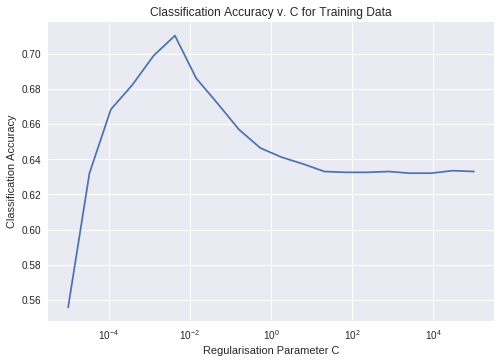

In [14]:
# Your code goes here
logspace = np.logspace(start=-5, stop=5, num=20)
scores = np.mean(score_array, axis=0)
plt.plot(logspace, scores)
plt.semilogx()
plt.xlabel("Regularisation Parameter C")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy v. C for Training Data")
plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [15]:
# Your code goes here
best_C = logspace[np.where(scores==scores.max())[0][0]]
print ("C value with highest accuracy: {:.3f}".format(best_C))
lr = LogisticRegression(solver="lbfgs", C=best_C).fit(X=X_tr, y=y_tr)
print ("Accuracy of new classifier on validation set: {:.3f}".format(lr.score(X=X_val, y=y_val)))

C value with highest accuracy: 0.004
Accuracy of new classifier on validation set: 0.696


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [16]:
# Your code goes here
lr = LogisticRegressionCV(solver="lbfgs", Cs=list(np.logspace(start=-5, stop=5, num=20)),\
                          cv=KFold(n=train_A.shape[0], n_folds=3, shuffle=True, random_state=0))
lr.fit(X=X_tr, y=y_tr)
print ("C value with highest accuracy: {:.3f}".format(lr.C_[0]))
print ("Accuracy of new classifier on validation set: {:.3f}".format(lr.score(X=X_val, y=y_val)))

C value with highest accuracy: 0.004
Accuracy of new classifier on validation set: 0.696


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [17]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=31).fit(X=X_tr, y=y_tr)
print ("RF accuracy on training set: {:.3f}".format(rf.score(X=X_tr, y=y_tr)))
print ("RF accuracy on validation set: {:.3f}".format(rf.score(X=X_val, y=y_val)))

RF accuracy on training set: 1.000
RF accuracy on validation set: 0.698


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

The discrepancy between the training and validation accuracies is not surprising. By nature of the Decision Tree and Random Forest algorithms, with such a large number of trees and an unspecified max_depth, the Random Forest classifier was expected to return a perfect accuracy. With an accuracy of just under 70% for the Logistic Regression Cross-Validation classifier it makes sense that the the Random Forest classifier would have an accuracy not much, if any, higher.

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [18]:
# Your code goes here
importances = pd.Series(rf.feature_importances_, index=att_list)
importances.sort_values(inplace=True, ascending=False)
for i in range(50):
    print ("The importance of the feature {} is: {:.6f}".format(importances.index[i], importances[i]))

The importance of the feature dim21 is: 0.007139
The importance of the feature dim479 is: 0.005916
The importance of the feature dim51 is: 0.005882
The importance of the feature dim360 is: 0.005620
The importance of the feature dim283 is: 0.005581
The importance of the feature dim76 is: 0.005270
The importance of the feature dim4 is: 0.004871
The importance of the feature dim461 is: 0.004384
The importance of the feature dim274 is: 0.004330
The importance of the feature dim330 is: 0.004298
The importance of the feature dim263 is: 0.004266
The importance of the feature dim343 is: 0.004186
The importance of the feature dim348 is: 0.004183
The importance of the feature dim217 is: 0.004156
The importance of the feature dim222 is: 0.004143
The importance of the feature dim347 is: 0.004060
The importance of the feature dim74 is: 0.004053
The importance of the feature dim356 is: 0.004045
The importance of the feature dim398 is: 0.003997
The importance of the feature dim423 is: 0.003889
The im

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [19]:
# Your code goes here
svc_linear = SVC(kernel="linear").fit(X=X_tr, y=y_tr)
svc_rbf = SVC(kernel="rbf").fit(X=X_tr, y=y_tr)
svc_poly = SVC(kernel="poly").fit(X=X_tr, y=y_tr)
print ("Accuracy of Linear SVC on training data: {:.3f}".format(svc_linear.score(X=X_tr, y=y_tr)))
print ("Accuracy of Linear SVC on validation data: {:.3f}".format(svc_linear.score(X=X_val, y=y_val)))
print ("Accuracy of RBF SVC on training data: {:.3f}".format(svc_rbf.score(X=X_tr, y=y_tr)))
print ("Accuracy of RBF SVC on validation data: {:.3f}".format(svc_rbf.score(X=X_val, y=y_val)))
print ("Accuracy of Polynomial SVC on training data: {:.3f}".format(svc_poly.score(X=X_tr, y=y_tr)))
print ("Accuracy of Polynomial SVC on validation data: {:.3f}".format(svc_poly.score(X=X_val, y=y_val)))

Accuracy of Linear SVC on training data: 0.842
Accuracy of Linear SVC on validation data: 0.639
Accuracy of RBF SVC on training data: 0.911
Accuracy of RBF SVC on validation data: 0.730
Accuracy of Polynomial SVC on training data: 0.991
Accuracy of Polynomial SVC on validation data: 0.702


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [20]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

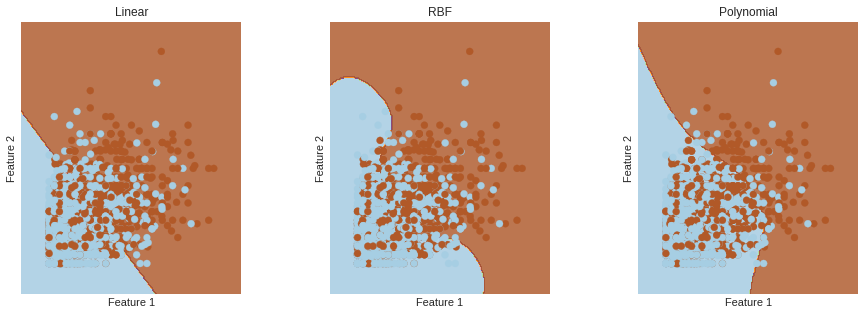

In [21]:
# Your code goes here
X = np.array([X_tr.T[20], X_tr.T[75]])
X = X.T
svc_linear = SVC(kernel="linear").fit(X=X, y=y_tr)
svc_rbf = SVC(kernel="rbf").fit(X=X, y=y_tr)
svc_poly = SVC(kernel="poly").fit(X=X, y=y_tr)
clfs = [svc_linear, svc_rbf, svc_poly]
title = ["Linear", "RBF", "Polynomial"]

show_svc_decision_boundaries(clfs=clfs, X=X, title=title)

The decision boundaries match the titles of the classifiers: A Linear SVC resulted in a linear decision boundary and a polynomial SVC resulted in a polynomial decision boundary. The RBF SVC results in a decision boundary that is difficult to describe in this feature space but the radial nature is evident from the two bulges near the center of the two axes.

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

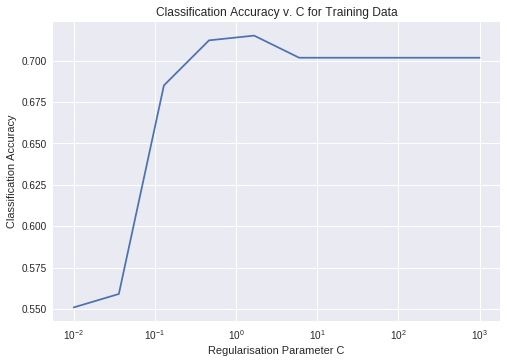

Best accuracy: 0.715
C value with highest accuracy: 1.668
Accuracy of new classifier on training set: 0.975
Accuracy of new classifier on validation set: 0.728


In [22]:
# Your code goes here
fold = 0
score_array = np.ndarray((3,10))
for kf_train_indices, kf_test_indices in kf:
    setting = 0
    for C in np.logspace(start=-2, stop=3, num=10):
        svc_rbf = SVC(kernel="rbf", C=C, gamma="auto").fit(X=X_tr[kf_train_indices], y=y_tr[kf_train_indices]) 
        score_array[fold, setting] = svc_rbf.score(X=X_tr[kf_test_indices], y=y_tr[kf_test_indices])
        setting +=1
    fold +=1
# Virtually same code as 1.13
logspace = np.logspace(start=-2, stop=3, num=10)
scores = np.mean(score_array, axis=0)
plt.plot(logspace, scores)
plt.semilogx()
plt.xlabel("Regularisation Parameter C")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy v. C for Training Data")
plt.show()
# Virtually same code as 1.14
best_C = logspace[np.where(scores==scores.max())[0][0]]
print ("Best accuracy: {:.3f}".format(scores.max()))
print ("C value with highest accuracy: {:.3f}".format(best_C))
svc_rbf = SVC(kernel="rbf", C=best_C, gamma="auto").fit(X=X_tr, y=y_tr)
print ("Accuracy of new classifier on training set: {:.3f}".format(svc_rbf.score(X=X_tr, y=y_tr)))
print ("Accuracy of new classifier on validation set: {:.3f}".format(svc_rbf.score(X=X_val, y=y_val)))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

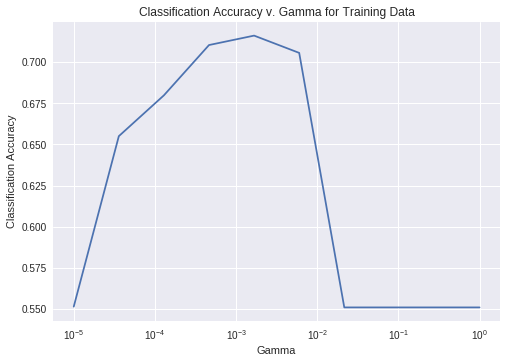

Best accuracy: 0.716
Gamma value with highest accuracy: 0.002
Accuracy of new classifier on training set: 0.891
Accuracy of new classifier on validation set: 0.727


In [23]:
# Your code goes here
fold = 0
score_array = np.ndarray((3,10))
for kf_train_indices, kf_test_indices in kf:
    setting = 0
    # This loop is essentially the only difference in code from the previous question
    for gamma in np.logspace(start=-5, stop=0, num=10):
        svc_rbf = SVC(kernel="rbf", C=1.0, gamma=gamma).fit(X=X_tr[kf_train_indices], y=y_tr[kf_train_indices]) 
        score_array[fold, setting] = svc_rbf.score(X=X_tr[kf_test_indices], y=y_tr[kf_test_indices])
        setting +=1
    fold +=1

logspace = np.logspace(start=-5, stop=0, num=10)
scores = np.mean(score_array, axis=0)
plt.plot(logspace, scores)
plt.semilogx()
plt.xlabel("Gamma")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy v. Gamma for Training Data")
plt.show()

best_gamma = logspace[np.where(scores==scores.max())[0][0]]
print ("Best accuracy: {:.3f}".format(scores.max()))
print ("Gamma value with highest accuracy: {:.3f}".format(best_gamma))
svc_rbf = SVC(kernel="rbf", C=1.0, gamma=best_gamma).fit(X=X_tr, y=y_tr)
print ("Accuracy of new classifier on training set: {:.3f}".format(svc_rbf.score(X=X_tr, y=y_tr)))
print ("Accuracy of new classifier on validation set: {:.3f}".format(svc_rbf.score(X=X_val, y=y_val)))

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

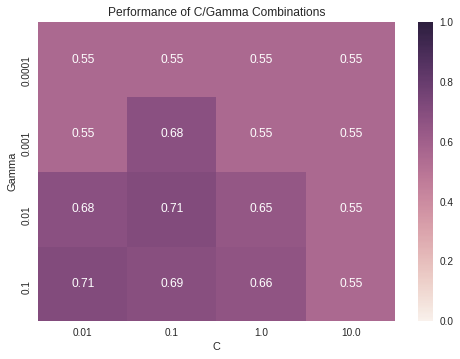

Best accuracy: 0.712
C/Gamma pair with highest accuracy: 0.100/0.010
Accuracy of new classifier on training set: 0.551
Accuracy of new classifier on validation set: 0.527


In [24]:
# Your code goes here 
plotting_array = np.ndarray((4,4))
C_array = np.logspace(start=-2, stop=1, num=4)
gamma_array = np.logspace(start=-4, stop=-1, num=4)

C_idx = 0
for C in C_array:
    gamma_idx = 0
    for gamma in gamma_array:
        score_list = []
        for kf_train_indices, kf_test_indices in kf:
            svc_rbf = SVC(kernel="rbf", C=C, gamma=gamma).fit(X=X_tr[kf_train_indices], y=y_tr[kf_train_indices])
            score_list.append(svc_rbf.score(X=X_tr[kf_test_indices], y=y_tr[kf_test_indices]))
        plotting_array[C_idx, gamma_idx] = sum(score_list)/len(score_list)
        gamma_idx +=1
    C_idx += 1

sns.heatmap(plotting_array, xticklabels=C_array, yticklabels=gamma_array, vmin=0., vmax=1., annot=True)
plt.xlabel("C")
plt.ylabel("Gamma")
plt.title("Performance of C/Gamma Combinations")
plt.show()

best_C = C_array[np.where(plotting_array==plotting_array.max())[1][0]]
best_gamma = gamma_array[np.where(plotting_array==plotting_array.max())[0][0]]
print ("Best accuracy: {:.3f}".format(plotting_array.max()))
print ("C/Gamma pair with highest accuracy: {:.3f}/{:.3f}".format(best_C, best_gamma))
svc_rbf = SVC(kernel="rbf", C=best_C, gamma=best_gamma).fit(X=X_tr, y=y_tr)
print ("Accuracy of new classifier on training set: {:.3f}".format(svc_rbf.score(X=X_tr, y=y_tr)))
print ("Accuracy of new classifier on validation set: {:.3f}".format(svc_rbf.score(X=X_val, y=y_val)))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*
A: The performance on the validation set was actually drastically reduced (around 50% instead of 70%). Tuning both the gamma and C parameters simultaneously double-penalizes distances. We would only want to optimize one of those parameters at a time. The classifier could be improved by increasing the number of kFolds (e.g. 5 or 10 folds is more common in practice) or by making use of the probability paramater in intializing and fitting the SVC classifier but these would both increase computational time pretty substantially.

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

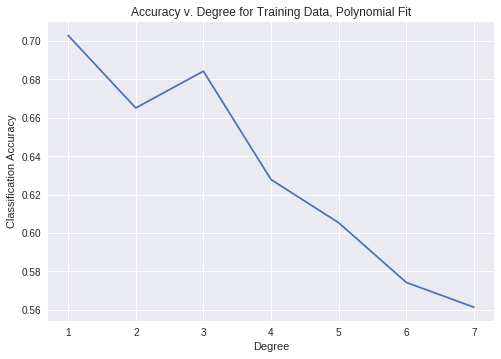

Best accuracy: 0.703
Degree value with highest accuracy: 1.000
Accuracy of new classifier on training set: 0.784
Accuracy of new classifier on validation set: 0.689


In [25]:
# Your code goes here
fold = 0
score_array = np.ndarray((3,7))
for kf_train_indices, kf_test_indices in kf:
    setting = 0
    for degree in np.arange(1,8):
        svc_poly = SVC(kernel="poly", degree = degree).fit(X=X_tr[kf_train_indices], y=y_tr[kf_train_indices]) 
        score_array[fold, setting] = svc_poly.score(X=X_tr[kf_test_indices], y=y_tr[kf_test_indices])
        setting +=1
    fold +=1
# Virtually same code as 1.13
x_values = np.arange(1,8)
scores = np.mean(score_array, axis=0)
plt.plot(x_values, scores)
plt.xlabel("Degree")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy v. Degree for Training Data, Polynomial Fit")
plt.show()
# Virtually same code as 1.14
best_degree = x_values[np.where(scores==scores.max())[0][0]]
print ("Best accuracy: {:.3f}".format(scores.max()))
print ("Degree value with highest accuracy: {:.3f}".format(best_degree))
svc_rbf = SVC(kernel="poly", degree=best_degree).fit(X=X_tr, y=y_tr)
print ("Accuracy of new classifier on training set: {:.3f}".format(svc_rbf.score(X=X_tr, y=y_tr)))
print ("Accuracy of new classifier on validation set: {:.3f}".format(svc_rbf.score(X=X_val, y=y_val)))

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*
The main advantage of using K-Fold cross-validation is that it trains on all of the training data. This means that, as compared to hold out validation that makes only one split, K-Folds is less vulnerable to the possibility of an unlucky split which is unrepresentative of the data as a whole. The main disadvantage of this method is the computational requirements, but if I had the computational resources available, I would trust the K-fold one more because of its robustness against bad splits.

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [26]:
# Your code goes here
X_tr = train_A.drop(["imgId", "is_person"], axis=1).as_matrix()
X_val = valid_A.drop(["imgId", "is_person"], axis=1).values
y_tr = train_A["is_person"].values
y_val = valid_A["is_person"].values
ss = StandardScaler().fit(X_tr)
X_tr = ss.transform(X_tr)
X_val = ss.transform(X_val)

rf = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=31).fit(X=X_tr, y=y_tr)
print ("Accuracy Score of Random Forest on Training Data: {:.3f}"\
      .format(rf.score(X=X_tr, y=y_tr)))
print ("Accuracy Score of Random Forest on Validation Data: {:.3f}"\
      .format(rf.score(X=X_val, y=y_val)))

importances = pd.Series(rf.feature_importances_, index=train_A.drop(["imgId", "is_person"], axis=1).columns)
importances.sort_values(inplace=True, ascending=False)
for i in range(50):
    print ("The importance of the feature {} is: {:.6f}".format(importances.index[i], importances[i]))

Accuracy Score of Random Forest on Training Data: 1.000
Accuracy Score of Random Forest on Validation Data: 0.712
The importance of the feature is_cat is: 0.009379
The importance of the feature is_bird is: 0.008731
The importance of the feature dim21 is: 0.008030
The importance of the feature dim51 is: 0.005925
The importance of the feature dim360 is: 0.005463
The importance of the feature dim4 is: 0.005325
The importance of the feature dim76 is: 0.005271
The importance of the feature dim398 is: 0.005254
The importance of the feature dim283 is: 0.004983
The importance of the feature dim479 is: 0.004942
The importance of the feature dim263 is: 0.004734
The importance of the feature dim343 is: 0.004609
The importance of the feature dim423 is: 0.004433
The importance of the feature dim485 is: 0.004245
The importance of the feature dim254 is: 0.004189
The importance of the feature dim461 is: 0.004158
The importance of the feature dim222 is: 0.004134
The importance of the feature dim356 is:

*Your answer goes here*
1. What I first notice is that the two most important features are actually the presence of another known feature. This means the presence of a bird or cat is more likely to indicate the presence of a person, or that a good number of images have both cats and people or both birds and people. 
2. The performance is slightly better than the performance of the classifier without the additional class indicator variables. This is because, as indicated by the two most important attributes in this classifier, the new classifier was able to take into account "True" data provided in the training data instead of relying on the more ambiguous clusters from the pre-processing.
3. The extent to which we could use these results as face value is basically the second sentence that I wrote in my answer to (1) in this question. Otherwise, we would have to try to figureout what "dim21", "dim51", etc. are using other methods.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*

Given data: Normally, given a large amount of data, I would split the data into training, validation, and testing sets. I would first pick a testing set. ThenI would use k-fold cross-validation to partition the remaining data into testing and validation sets, using averages over folds to optimize parameters. I would probably use 5- or 10-fold validation as these seem to be the most commonly used in practice with good trade-offs between accuracy and computational time. However, the data provided has already been split into training and validation, which effectively creates hold out validation. I could concatenate train_B and valid_B into one large data set, then use k-fold cross-validation across the 3000 instances. However, given the scope of this assignment and the way in which the data was provided, I assume from here on that it is implied to use hold-out validation with the training and validation sets provided.

Preprocessing: The first step, like above, was to remove the imageID because it contains no information about whether an image contains a person or not. It also makes intuitive sense to remove the "is_cat", "is_bird", etc. attributes, so I did that as well. If all of these pictures were from an album with a common theme, there would be a much higher probability that a class indicator variable would correlate with the label. For example, if the album was The Bird-Watching Society's Annual Album then "is_bird" would probably show a correlation with "is_person". However, since I have no information about these albums I have to assume that the pictures are random. I recognize that in Part 1 with the Random Forest classifiers we identified that considering all of the class indicator variables improved accuracy. However, this improvement was very slight (less than two percent increase) and may have been due to chance. Concerning outliers, since we assumed that the images did not have a common theme, the main outlier problem I could think of would have been if there were bad images (e.g. an image that was completely black). I assumed that these images would have been found in the SIFT/Bag of Visual Words preprocessing and thus that the data that we were presented with did not have outliers.

Linear Regression was obviously not an option for this task because it is used for regression and not classification. Since we don't have any missing data, classifiers such as kNN which require filling in of missing data are not a problem. Besides this elimination, it seems that the best option, time permitting, would be to run simulations for each other classification algorithm we have learned (NB, DT, Logistic Regression, kNN, SVC). For each algorithm I trained on the training data, used the validation data to optimize the parameters, then tested on the test data. Each approach required certain feature analysis; for example, I used Bernoulli Naive Bayes because the data is all in a "contains x" where x is the "dim1 dim2 ... dim500" clusters done in preprocessing before the data was provided to us. Logistic Regression and SVC required scaling on the X values which I did when I tested them.

In total, I tested the following algorithms optimizing their following parameters
BernoulliNB, parameter = alpha
DT, parameter = max_depth
kNN, parameter = n_estimators
Logistic Regerssion, parameter = C
SVC, parameter = C
SVC, parameter = gamma

The best result was the Random Forest classifier. I pasted the code to it below but the code for evaluating the other algorithms was in a very similar format, changing only the classifier initiation and the range of parameter values tested based on the algorithm (i.e. log values for C for SVC, integer values for kNN). 

In [27]:
# Your code goes here
# Load the dataset and split into test/train datasets
data_path_train = os.path.join(os.getcwd(), "datasets", "train_images_partB.csv")
train_B = pd.read_csv(data_path_train, delimiter = ",")
data_path_valid = os.path.join(os.getcwd(), "datasets", "valid_images_partB.csv")
valid_B = pd.read_csv(data_path_valid, delimiter = ",")
data_path_test = os.path.join(os.getcwd(), "datasets", "test_images_partB.csv")
test_B = pd.read_csv(data_path_test, delimiter = ",")
X_tr = train_B[att_list].as_matrix()
X_val = valid_B[att_list].values
X_test = test_B[att_list].values
y_tr = train_B["is_person"].values
y_val = valid_B["is_person"].values
y_test = test_B["is_person"].values
#Logistic
best_param = 0
best_loss = 1000
# param is C
for param in range(1,10):
    lr = LogisticRegression(solver="lbfgs", C=param).fit(X=X_tr, y=y_tr)
    predictions = lr.predict(X=X_val)
    loss = log_loss(y_true=y_val, y_pred=predictions)
    if loss < best_loss:
        best_param = param
        best_loss = loss
lr_new = LogisticRegression(solver="lbfgs", C=best_param).fit(X=X_tr, y=y_tr)
predictions_new = lr_new.predict(X=X_test)
#Dataset altered from original assignment, causing Exception in next two lines
#final_loss = log_loss(y_true=y_test, y_pred=predictions_new)
#print ("Logistic Regression Final loss:", final_loss)

ValueError: y_true contains only one label (?). Please provide the true labels explicitly through the labels argument.

In [ ]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

*Your answer goes here*

